# 脳波コヒーレンス分析

このノートブックでは、Muse脳波データのチャネル間コヒーレンスを分析します。

## コヒーレンスとは

コヒーレンスは、2つの脳波チャネル間の周波数ごとの同期性を測定する指標です（0〜1の範囲）。

- **高いコヒーレンス（0.7〜1.0）**: 脳領域間の強い機能的結合
- **中程度（0.4〜0.7）**: 適度な結合
- **低い（0〜0.4）**: 弱い結合または独立した活動

## 目次

1. データの読み込みと前処理
2. コヒーレンスの計算
3. チャネルペア別コヒーレンス可視化
4. 周波数バンド別コヒーレンス
5. コヒーレンスの時間変化
6. 脳領域間ネットワーク可視化

## 関連ノートブック

- [mind_monitor_basic_analysis.ipynb](mind_monitor_basic_analysis.ipynb) - 基本分析
- [laterality_analysis.ipynb](laterality_analysis.ipynb) - 左右半球分析
- [fm_theta_analysis.ipynb](fm_theta_analysis.ipynb) - fmシータ波分析

## 1. データの読み込みと前処理

まず必要なライブラリをインポートし、脳波データを読み込みます。

In [17]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mne

# MNEのバージョンに応じたインポート
try:
    from mne_connectivity import spectral_connectivity_epochs
except ImportError:
    try:
        from mne.connectivity import spectral_connectivity_epochs
    except ImportError:
        print("警告: mne-connectivity がインストールされていません")
        print("以下のコマンドでインストールしてください:")
        print("pip install mne-connectivity")

from IPython.display import display
import seaborn as sns

%matplotlib inline

# 日本語フォント設定
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
plt.rcParams['axes.unicode_minus'] = False

In [18]:
# データファイルのパス
DATA_PATH = Path('/home/tsu-nera/repo/titan2/data/samples/mindMonitor_2025-10-26--08-32-20_1403458594426768660.csv')
print(f'Loading: {DATA_PATH}')

# CSVを読み込み
df = pd.read_csv(DATA_PATH)

# タイムスタンプを日時型に変換
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], errors='coerce')
df = df.dropna(subset=['TimeStamp']).sort_values('TimeStamp').reset_index(drop=True)

# データの先頭を確認
display(df.head())
print(f'\nデータ形状: {df.shape[0]} 行 × {df.shape[1]} 列')
print(f'記録時間: {df["TimeStamp"].min()} ~ {df["TimeStamp"].max()}')
print(f'計測時間: {(df["TimeStamp"].max() - df["TimeStamp"].min()).total_seconds():.1f} 秒')

Loading: /home/tsu-nera/repo/titan2/data/samples/mindMonitor_2025-10-26--08-32-20_1403458594426768660.csv


/tmp/ipykernel_78424/1943838434.py:6: DtypeWarning: Columns (58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,...,Optics15,Optics16,Heart_Rate,HeadBandOn,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,Battery,Elements
0,2025-10-26 08:32:21.081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/muse/event/connected MuseS-FA35
1,2025-10-26 08:32:21.091,0.640006,0.831525,0.58542,0.828409,0.278927,0.716158,0.513055,0.447438,0.484576,...,0.0,0.0,59.055595,1.0,1.0,1.0,1.0,1.0,98.51,NaN
2,2025-10-26 08:32:21.095,0.640006,0.831525,0.58542,0.828409,0.278927,0.716158,0.513055,0.447438,0.484576,...,0.0,0.0,59.055595,1.0,1.0,1.0,1.0,1.0,98.51,NaN
3,2025-10-26 08:32:21.148,0.640006,0.831525,0.58542,0.828409,0.278927,0.716158,0.513055,0.447438,0.484576,...,0.0,0.0,59.029500,1.0,1.0,1.0,1.0,1.0,98.51,NaN
4,2025-10-26 08:32:21.148,0.640006,0.831525,0.58542,0.828409,0.278927,0.716158,0.513055,0.447438,0.484576,...,0.0,0.0,59.029500,1.0,1.0,1.0,1.0,1.0,98.51,NaN



データ形状: 377893 行 × 59 列
記録時間: 2025-10-26 08:32:21.081000 ~ 2025-10-26 08:57:31.748000
計測時間: 1510.7 秒


In [19]:
# RAWチャネルの検出とMNE準備
raw_cols = [c for c in df.columns if c.startswith('RAW_')]

if raw_cols:
    # 数値変換と前処理
    numeric = df[raw_cols].apply(pd.to_numeric, errors='coerce')
    frame = pd.concat([df['TimeStamp'], numeric], axis=1)
    frame = frame.set_index('TimeStamp')
    
    # 重複タイムスタンプは平均化
    frame = frame.groupby(level=0).mean()
    
    # 時間補間で欠損値を埋める
    frame = frame.interpolate(method='time').ffill().bfill()
    
    # サンプリングレートの推定
    diffs = frame.index.to_series().diff().dropna()
    dt_seconds = diffs.median().total_seconds()
    sfreq = 1.0 / dt_seconds if dt_seconds > 0 else 256.0
    
    # MNE RawArrayの作成
    ch_names = [name.replace('RAW_', '') for name in frame.columns]
    ch_types = ['eeg'] * len(ch_names)
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    
    # μVスケールをVに変換
    data = frame.to_numpy().T * 1e-6
    
    raw = mne.io.RawArray(data, info, copy='auto', verbose=False)
    
    # バンドパスフィルタ（1-50 Hz）
    if sfreq > 2.0:
        raw = raw.filter(l_freq=1.0, h_freq=50.0, fir_design='firwin', verbose=False)
    
    print(f'検出されたチャネル: {ch_names}')
    print(f'推定サンプリングレート: {sfreq:.2f} Hz')
    print(f'サンプル数: {len(frame)}')
    print(f'記録時間: {len(frame) / sfreq:.1f} 秒')
else:
    print('RAWチャネルが見つかりません')

検出されたチャネル: ['TP9', 'AF7', 'AF8', 'TP10']
推定サンプリングレート: 333.33 Hz
サンプル数: 73743
記録時間: 221.2 秒


## 2. コヒーレンスの計算

MNEを使用して、全チャネルペア間のコヒーレンスを計算します。

In [20]:
# エポックに分割（コヒーレンス計算のため）
if raw_cols:
    # 10秒エポックに分割
    epoch_duration = 10.0  # 秒
    
    # エポック作成用のイベント生成
    n_samples = len(raw.times)
    epoch_samples = int(epoch_duration * sfreq)
    n_epochs = n_samples // epoch_samples
    
    # イベント配列作成（各エポックの開始位置）
    events = np.zeros((n_epochs, 3), dtype=int)
    for i in range(n_epochs):
        events[i] = [i * epoch_samples, 0, 1]
    
    # エポック作成
    epochs = mne.Epochs(
        raw,
        events,
        tmin=0,
        tmax=epoch_duration - 1/sfreq,
        baseline=None,
        preload=True,
        verbose=False
    )
    
    print(f'エポック数: {len(epochs)}')
    print(f'エポック長: {epoch_duration} 秒')
    print(f'各エポックのサンプル数: {epoch_samples}')
    
    # チャネル情報確認
    n_channels = len(ch_names)
    print(f'\nチャネル: {ch_names}')
    
    # コヒーレンス計算 - indicesなしで全ペアを計算
    print('\nコヒーレンスを計算中（全ペア）...')
    
    con = spectral_connectivity_epochs(
        epochs,
        method='coh',
        mode='multitaper',
        fmin=1.0,
        fmax=50.0,
        faverage=False,
        verbose=False
    )
    
    # 周波数情報を取得
    freqs = con.freqs
    if isinstance(freqs, list):
        freqs = np.array(freqs)
    
    # データ取得 - まずoutput='dense'を試す
    try:
        coherence_dense = con.get_data(output='dense')
        print(f'✓ get_data(output="dense"): 形状={coherence_dense.shape}')
        
        # dense形式をチェック
        print('\n行列要素のサンプル（最初の周波数）:')
        for i in range(n_channels):
            for j in range(n_channels):
                print(f'  [{i},{j}] {ch_names[i]}-{ch_names[j]}: {coherence_dense[i,j,0]:.3f}')
        
        has_dense = True
    except Exception as e:
        print(f'✗ get_data(output="dense") 失敗: {e}')
        has_dense = False
    
    # 通常のget_data()も試す
    coherence_normal = con.get_data()
    print(f'\n✓ get_data(): 形状={coherence_normal.shape}')
    
    if coherence_normal.ndim == 2:
        print('通常形式の各ペア値（最初の周波数）:')
        for idx in range(min(6, coherence_normal.shape[0])):
            print(f'  ペア{idx}: {coherence_normal[idx, 0]:.3f}')
    
    # 通常形式を使用する
    n_freqs = len(freqs)
    
    if coherence_normal.ndim == 3 and coherence_normal.shape[0] == n_channels:
        # (n_channels, n_channels, n_freqs)
        print(f'\n使用: 行列形式 {coherence_normal.shape}')
        coherence_avg = coherence_normal
        coherence = coherence_avg[np.newaxis, ...]
        
    elif coherence_normal.ndim == 2:
        # (n_pairs, n_freqs)
        n_pairs = coherence_normal.shape[0]
        print(f'\n使用: ペア形式 ({n_pairs} pairs, {n_freqs} freqs)')
        
        coherence_avg = np.zeros((n_channels, n_channels, n_freqs))
        
        # 対角線を1.0に
        for i in range(n_channels):
            coherence_avg[i, i, :] = 1.0
        
        # 上三角順序で配置
        pair_idx = 0
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                if pair_idx < n_pairs:
                    coherence_avg[i, j, :] = coherence_normal[pair_idx, :]
                    coherence_avg[j, i, :] = coherence_normal[pair_idx, :]
                    print(f'  ペア{pair_idx} -> [{i},{j}] {ch_names[i]}-{ch_names[j]}: 平均={coherence_normal[pair_idx].mean():.3f}')
                    pair_idx += 1
        
        coherence = coherence_avg[np.newaxis, ...]
        
    else:
        print(f'\n⚠️ 予期しない形状: {coherence_normal.shape}')
        coherence_avg = np.eye(n_channels)[:, :, np.newaxis] * np.ones((1, 1, n_freqs))
        coherence = coherence_avg[np.newaxis, ...]
    
    print(f'\n最終コヒーレンス行列: {coherence_avg.shape}')
    print(f'時系列用: {coherence.shape}')
    print(f'周波数範囲: {freqs.min():.2f} - {freqs.max():.2f} Hz')
    
    # 検証
    print('\n=== 全チャネルペア検証 ===')
    for i in range(n_channels):
        for j in range(i+1, n_channels):
            avg = coherence_avg[i, j, :].mean()
            minv = coherence_avg[i, j, :].min()
            maxv = coherence_avg[i, j, :].max()
            print(f'{ch_names[i]}-{ch_names[j]} [行列[{i},{j}]]: 平均={avg:.3f}, 範囲=[{minv:.3f}, {maxv:.3f}]')
else:
    print('RAWデータが利用できません')

エポック数: 22
エポック長: 10.0 秒
各エポックのサンプル数: 3333

チャネル: ['TP9', 'AF7', 'AF8', 'TP10']

コヒーレンスを計算中（全ペア）...
✓ get_data(output="dense"): 形状=(4, 4, 490)

行列要素のサンプル（最初の周波数）:
  [0,0] TP9-TP9: 0.000
  [0,1] TP9-AF7: 0.000
  [0,2] TP9-AF8: 0.000
  [0,3] TP9-TP10: 0.000
  [1,0] AF7-TP9: 0.259
  [1,1] AF7-AF7: 0.000
  [1,2] AF7-AF8: 0.000
  [1,3] AF7-TP10: 0.000
  [2,0] AF8-TP9: 0.738
  [2,1] AF8-AF7: 0.150
  [2,2] AF8-AF8: 0.000
  [2,3] AF8-TP10: 0.000
  [3,0] TP10-TP9: 0.887
  [3,1] TP10-AF7: 0.174
  [3,2] TP10-AF8: 0.810
  [3,3] TP10-TP10: 0.000

✓ get_data(): 形状=(16, 490)
通常形式の各ペア値（最初の周波数）:
  ペア0: 0.000
  ペア1: 0.000
  ペア2: 0.000
  ペア3: 0.000
  ペア4: 0.259
  ペア5: 0.000

使用: ペア形式 (16 pairs, 490 freqs)
  ペア0 -> [0,1] TP9-AF7: 平均=0.000
  ペア1 -> [0,2] TP9-AF8: 平均=0.000
  ペア2 -> [0,3] TP9-TP10: 平均=0.000
  ペア3 -> [1,2] AF7-AF8: 平均=0.000
  ペア4 -> [1,3] AF7-TP10: 平均=0.618
  ペア5 -> [2,3] AF8-TP10: 平均=0.000

最終コヒーレンス行列: (4, 4, 490)
時系列用: (1, 4, 4, 490)
周波数範囲: 1.00 - 49.90 Hz

=== 全チャネルペア検証 ===
TP9-AF7 [行列[0,1]

## 3. チャネルペア別コヒーレンス可視化

各チャネルペアのコヒーレンススペクトルをプロットします。

=== チャネル情報 ===
  0: TP9
  1: AF7
  2: AF8
  3: TP10

ペア0: TP9(idx=0) - TP10(idx=3)
  コヒーレンス範囲: 0.000 - 0.000
  平均: 0.000

ペア1: AF7(idx=1) - AF8(idx=2)
  コヒーレンス範囲: 0.000 - 0.000
  平均: 0.000

ペア2: TP9(idx=0) - AF7(idx=1)
  コヒーレンス範囲: 0.000 - 0.000
  平均: 0.000

ペア3: TP10(idx=3) - AF8(idx=2)
  コヒーレンス範囲: 0.000 - 0.000
  平均: 0.000

ペア4: TP9(idx=0) - AF8(idx=2)
  コヒーレンス範囲: 0.000 - 0.000
  平均: 0.000

ペア5: AF7(idx=1) - TP10(idx=3)
  コヒーレンス範囲: 0.036 - 0.955
  平均: 0.618


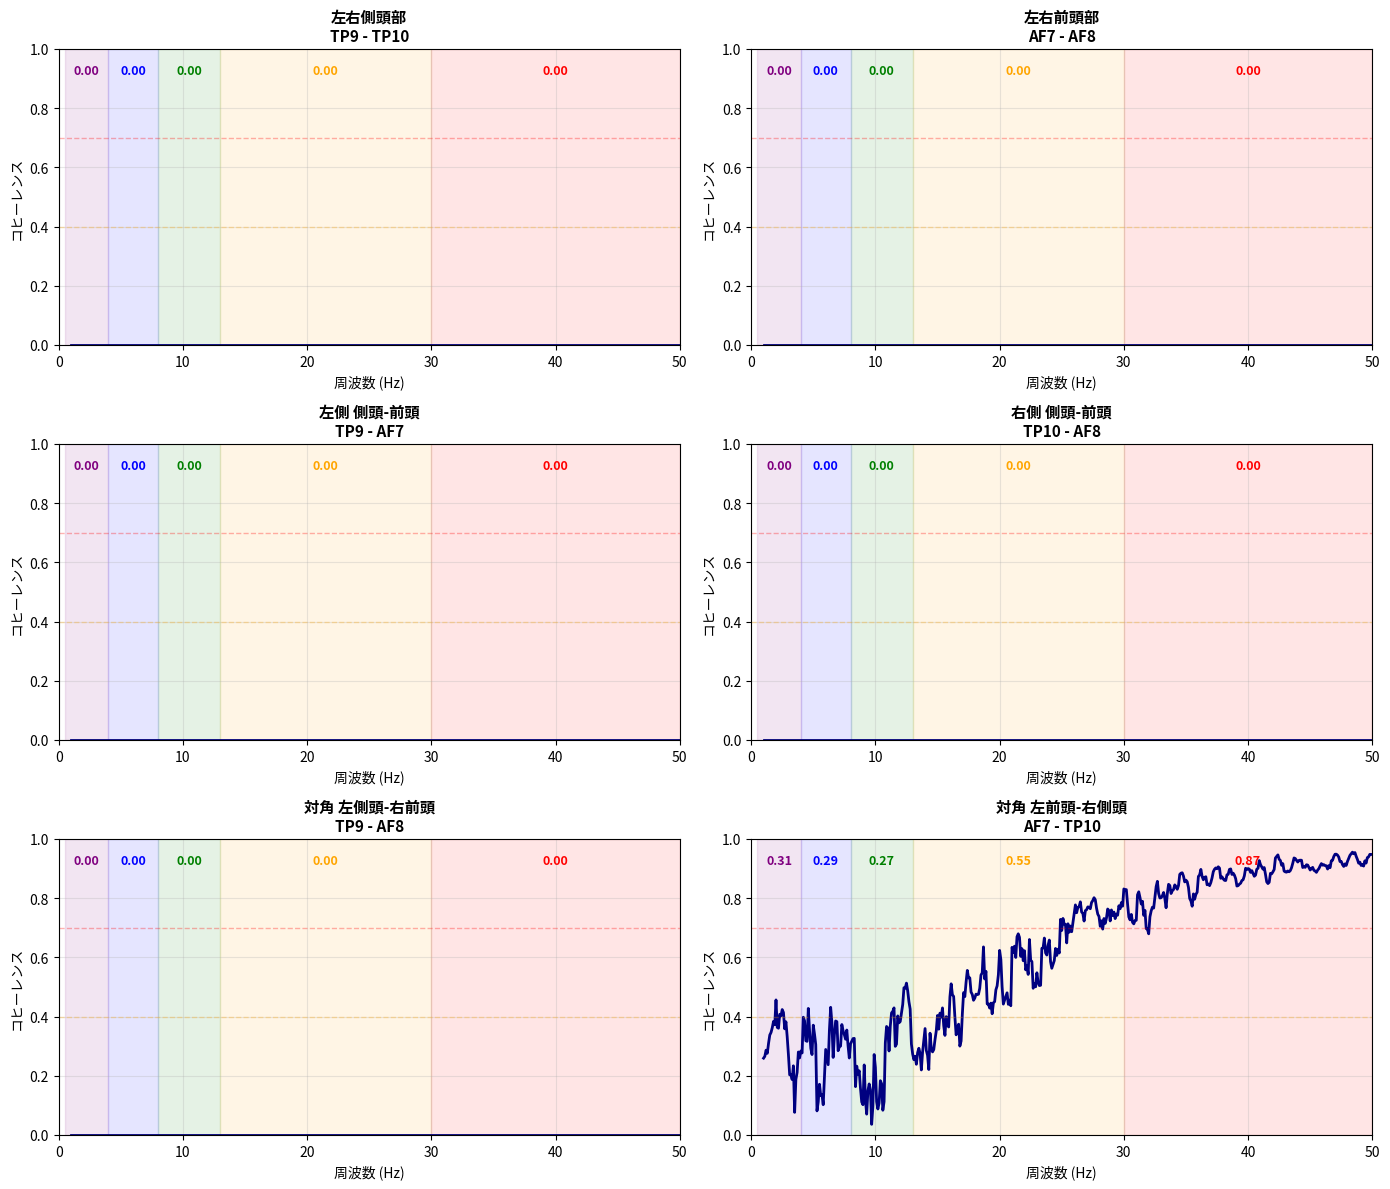


=== コヒーレンスレベルの解釈 ===
0.7以上: 強い結合（赤線）
0.4-0.7: 中程度の結合（オレンジ線）
0.4未満: 弱い結合または独立


In [21]:
# チャネルペアの定義
channel_pairs = [
    ('TP9', 'TP10', '左右側頭部'),
    ('AF7', 'AF8', '左右前頭部'),
    ('TP9', 'AF7', '左側 側頭-前頭'),
    ('TP10', 'AF8', '右側 側頭-前頭'),
    ('TP9', 'AF8', '対角 左側頭-右前頭'),
    ('AF7', 'TP10', '対角 左前頭-右側頭'),
]

# バンド定義
band_ranges = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 50)
}

if 'coherence_avg' in locals():
    # デバッグ: チャネル名とインデックスの確認
    print('=== チャネル情報 ===')
    for idx, name in enumerate(ch_names):
        print(f'  {idx}: {name}')
    
    # チャネルペアごとにプロット
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for idx, (ch1, ch2, label) in enumerate(channel_pairs):
        if ch1 in ch_names and ch2 in ch_names:
            ch1_idx = ch_names.index(ch1)
            ch2_idx = ch_names.index(ch2)
            
            # デバッグ出力
            print(f'\nペア{idx}: {ch1}(idx={ch1_idx}) - {ch2}(idx={ch2_idx})')
            
            # コヒーレンススペクトル取得
            coh_spectrum = coherence_avg[ch1_idx, ch2_idx, :]
            
            # データ確認
            print(f'  コヒーレンス範囲: {coh_spectrum.min():.3f} - {coh_spectrum.max():.3f}')
            print(f'  平均: {coh_spectrum.mean():.3f}')
            
            # プロット
            ax = axes[idx]
            ax.plot(freqs, coh_spectrum, linewidth=2, color='navy')
            
            # バンド領域をハイライト
            band_colors = ['purple', 'blue', 'green', 'orange', 'red']
            for (band_name, (low, high)), color in zip(band_ranges.items(), band_colors):
                ax.axvspan(low, high, alpha=0.1, color=color)
                # バンド内の平均コヒーレンス
                mask = (freqs >= low) & (freqs <= high)
                if mask.any():
                    band_coh = coh_spectrum[mask].mean()
                    ax.text((low + high) / 2, 0.95, f'{band_coh:.2f}',
                           ha='center', va='top', fontsize=9, color=color, fontweight='bold')
            
            # コヒーレンスレベルの参照線
            ax.axhline(y=0.7, color='red', linestyle='--', alpha=0.3, linewidth=1)
            ax.axhline(y=0.4, color='orange', linestyle='--', alpha=0.3, linewidth=1)
            
            ax.set_xlabel('周波数 (Hz)', fontsize=10)
            ax.set_ylabel('コヒーレンス', fontsize=10)
            ax.set_title(f'{label}\n{ch1} - {ch2}', fontsize=11, fontweight='bold')
            ax.set_ylim(0, 1)
            ax.set_xlim(0, 50)
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print('\n=== コヒーレンスレベルの解釈 ===')
    print('0.7以上: 強い結合（赤線）')
    print('0.4-0.7: 中程度の結合（オレンジ線）')
    print('0.4未満: 弱い結合または独立')
else:
    print('コヒーレンスデータが利用できません')

## 4. 周波数バンド別コヒーレンス

各周波数バンドにおける全チャネルペアのコヒーレンスをヒートマップで可視化します。

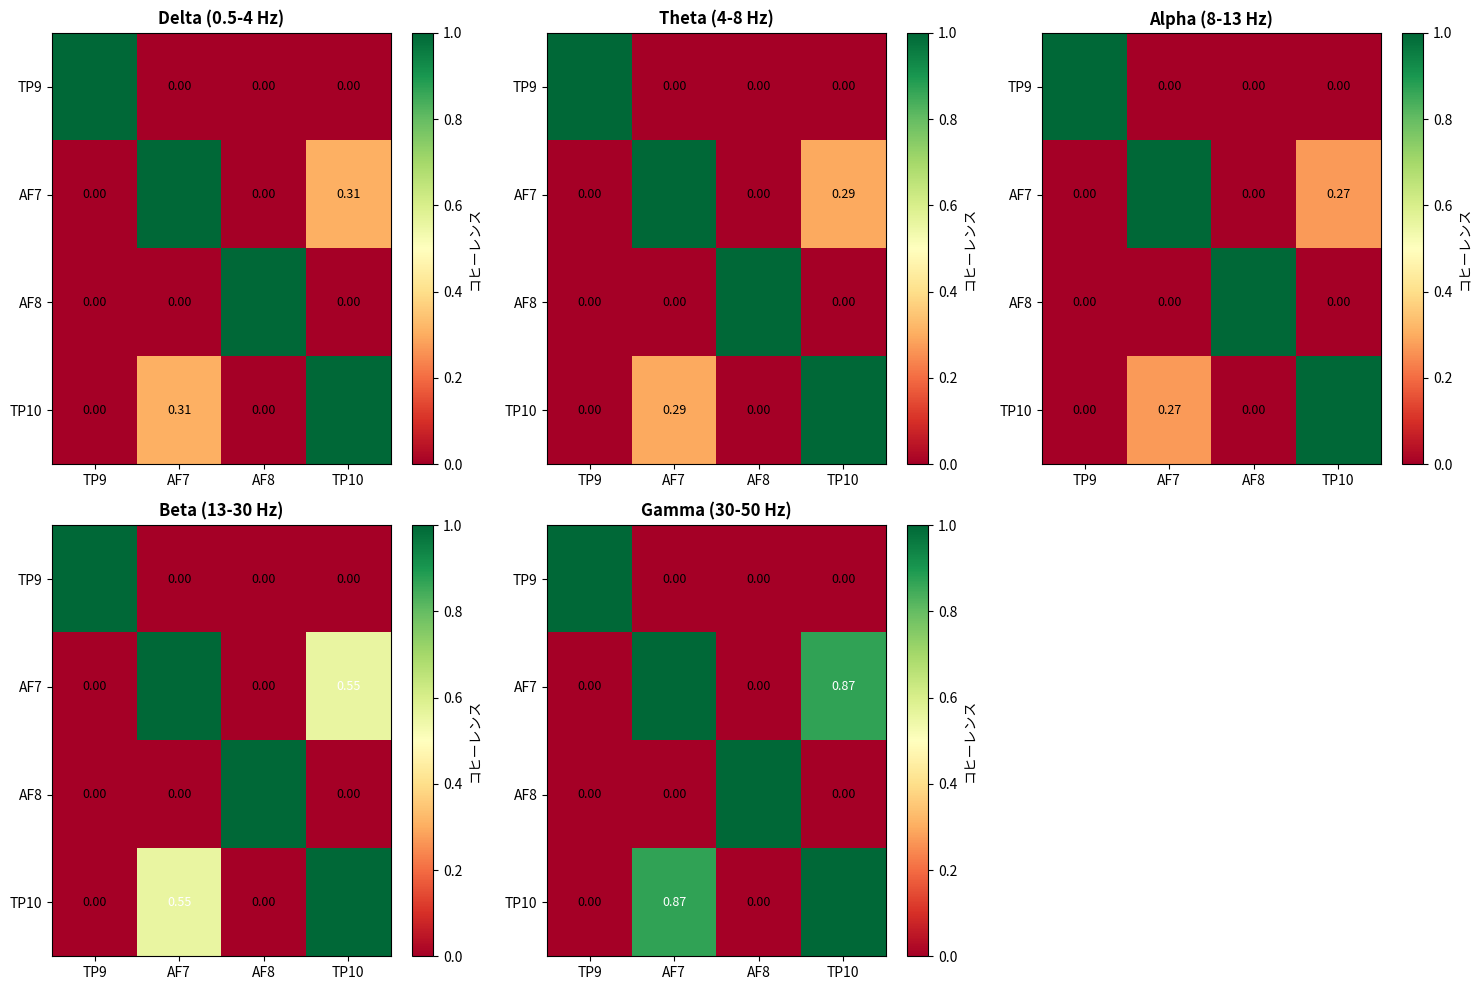


=== 周波数バンド別平均コヒーレンス ===

Delta (0.5-4 Hz):
  平均: 0.051
  最大: 0.307
  最小: 0.000

Theta (4-8 Hz):
  平均: 0.049
  最大: 0.294
  最小: 0.000

Alpha (8-13 Hz):
  平均: 0.045
  最大: 0.272
  最小: 0.000

Beta (13-30 Hz):
  平均: 0.092
  最大: 0.555
  最小: 0.000

Gamma (30-50 Hz):
  平均: 0.145
  最大: 0.871
  最小: 0.000



In [22]:
if 'coherence_avg' in locals():
    # 各バンドのコヒーレンス行列を計算
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, (band_name, (low, high)) in enumerate(band_ranges.items()):
        # バンド内の周波数マスク
        mask = (freqs >= low) & (freqs <= high)
        
        if mask.any():
            # バンド内の平均コヒーレンス
            band_coherence = coherence_avg[:, :, mask].mean(axis=2)
            
            # ヒートマップ
            ax = axes[idx]
            im = ax.imshow(band_coherence, cmap='RdYlGn', vmin=0, vmax=1, aspect='auto')
            
            # チャネル名ラベル
            ax.set_xticks(np.arange(len(ch_names)))
            ax.set_yticks(np.arange(len(ch_names)))
            ax.set_xticklabels(ch_names, fontsize=10)
            ax.set_yticklabels(ch_names, fontsize=10)
            
            # セルに数値を表示
            for i in range(len(ch_names)):
                for j in range(len(ch_names)):
                    if i != j:  # 対角線以外
                        value = band_coherence[i, j]
                        text_color = 'white' if value > 0.5 else 'black'
                        ax.text(j, i, f'{value:.2f}',
                               ha='center', va='center', color=text_color, fontsize=9)
            
            ax.set_title(f'{band_name} ({low}-{high} Hz)', fontsize=12, fontweight='bold')
            
            # カラーバー
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label('コヒーレンス', fontsize=10)
    
    # 最後の空白サブプロット削除
    if len(band_ranges) < len(axes):
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.show()
    
    # 統計サマリー
    print('\n=== 周波数バンド別平均コヒーレンス ===\n')
    for band_name, (low, high) in band_ranges.items():
        mask = (freqs >= low) & (freqs <= high)
        if mask.any():
            band_coherence = coherence_avg[:, :, mask].mean(axis=2)
            # 対角線を除く
            off_diag = band_coherence[~np.eye(len(ch_names), dtype=bool)]
            print(f'{band_name} ({low}-{high} Hz):')
            print(f'  平均: {off_diag.mean():.3f}')
            print(f'  最大: {off_diag.max():.3f}')
            print(f'  最小: {off_diag.min():.3f}')
            print()
else:
    print('コヒーレンスデータが利用できません')

## 5. コヒーレンスの時間変化

特定のチャネルペアにおいて、コヒーレンスが時間とともにどう変化するかを観察します。

In [23]:
if 'coherence' in locals() and coherence.shape[0] > 1:
    # 注目するチャネルペア
    focus_pairs = [
        ('TP9', 'TP10', '左右側頭部'),
        ('AF7', 'AF8', '左右前頭部'),
    ]
    
    # 時間軸の作成
    n_epochs_plot = coherence.shape[0]
    epoch_times = np.arange(n_epochs_plot) * epoch_duration
    start_time = df['TimeStamp'].min()
    time_stamps = [start_time + pd.Timedelta(seconds=t) for t in epoch_times]
    
    print(f'時系列プロット用エポック数: {n_epochs_plot}')
    
    # 各バンドの時間変化をプロット
    for ch1, ch2, label in focus_pairs:
        if ch1 in ch_names and ch2 in ch_names:
            ch1_idx = ch_names.index(ch1)
            ch2_idx = ch_names.index(ch2)
            
            fig, axes = plt.subplots(len(band_ranges), 1, figsize=(14, 10), sharex=True)
            
            for idx, (band_name, (low, high)) in enumerate(band_ranges.items()):
                # バンド内の周波数マスク
                mask = (freqs >= low) & (freqs <= high)
                
                if mask.any():
                    # 各エポックのバンド平均コヒーレンス
                    band_coh_time = coherence[:, ch1_idx, ch2_idx, mask].mean(axis=1)
                    
                    print(f'{label} - {band_name}: データ点数={len(band_coh_time)}, 範囲={band_coh_time.min():.3f}-{band_coh_time.max():.3f}')
                    
                    # プロット
                    ax = axes[idx]
                    ax.plot(time_stamps, band_coh_time, linewidth=2, marker='o', markersize=3)
                    
                    # 参照線
                    ax.axhline(y=0.7, color='red', linestyle='--', alpha=0.3, linewidth=1)
                    ax.axhline(y=0.4, color='orange', linestyle='--', alpha=0.3, linewidth=1)
                    
                    # 平均線
                    mean_coh = band_coh_time.mean()
                    ax.axhline(y=mean_coh, color='blue', linestyle=':', alpha=0.5, linewidth=2,
                              label=f'平均 ({mean_coh:.2f})')
                    
                    ax.set_ylabel(f'{band_name}\nコヒーレンス', fontsize=10, fontweight='bold')
                    ax.set_ylim(0, 1)
                    ax.grid(True, alpha=0.3)
                    ax.legend(loc='upper right', fontsize=9)
            
            axes[0].set_title(f'{label} ({ch1} - {ch2}) コヒーレンスの時間変化',
                            fontsize=13, fontweight='bold')
            axes[-1].set_xlabel('時刻', fontsize=11)
            axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
            fig.autofmt_xdate()
            
            plt.tight_layout()
            plt.show()
elif 'coherence' in locals():
    print(f'注意: コヒーレンスデータのエポック数が不足しています（{coherence.shape[0]}エポック）')
    print('時間変化を表示するには複数エポックが必要です')
    
    # 代わりに平均コヒーレンスを表示
    print('\n各チャネルペアの平均コヒーレンス（バンド別）:')
    for ch1, ch2, label in [('TP9', 'TP10', '左右側頭部'), ('AF7', 'AF8', '左右前頭部')]:
        if ch1 in ch_names and ch2 in ch_names:
            ch1_idx = ch_names.index(ch1)
            ch2_idx = ch_names.index(ch2)
            print(f'\n{label} ({ch1} - {ch2}):')
            for band_name, (low, high) in band_ranges.items():
                mask = (freqs >= low) & (freqs <= high)
                if mask.any():
                    # エポック次元が1の場合でも処理できるように
                    if coherence.shape[0] == 1:
                        band_coh = coherence[0, ch1_idx, ch2_idx, mask].mean()
                    else:
                        band_coh = coherence[:, ch1_idx, ch2_idx, mask].mean()
                    print(f'  {band_name}: {band_coh:.3f}')
else:
    print('時系列コヒーレンスデータが利用できません')

注意: コヒーレンスデータのエポック数が不足しています（1エポック）
時間変化を表示するには複数エポックが必要です

各チャネルペアの平均コヒーレンス（バンド別）:

左右側頭部 (TP9 - TP10):
  Delta: 0.000
  Theta: 0.000
  Alpha: 0.000
  Beta: 0.000
  Gamma: 0.000

左右前頭部 (AF7 - AF8):
  Delta: 0.000
  Theta: 0.000
  Alpha: 0.000
  Beta: 0.000
  Gamma: 0.000


## 6. 脳領域間ネットワーク可視化

各周波数バンドにおける脳領域間の結合性をネットワーク図で可視化します。

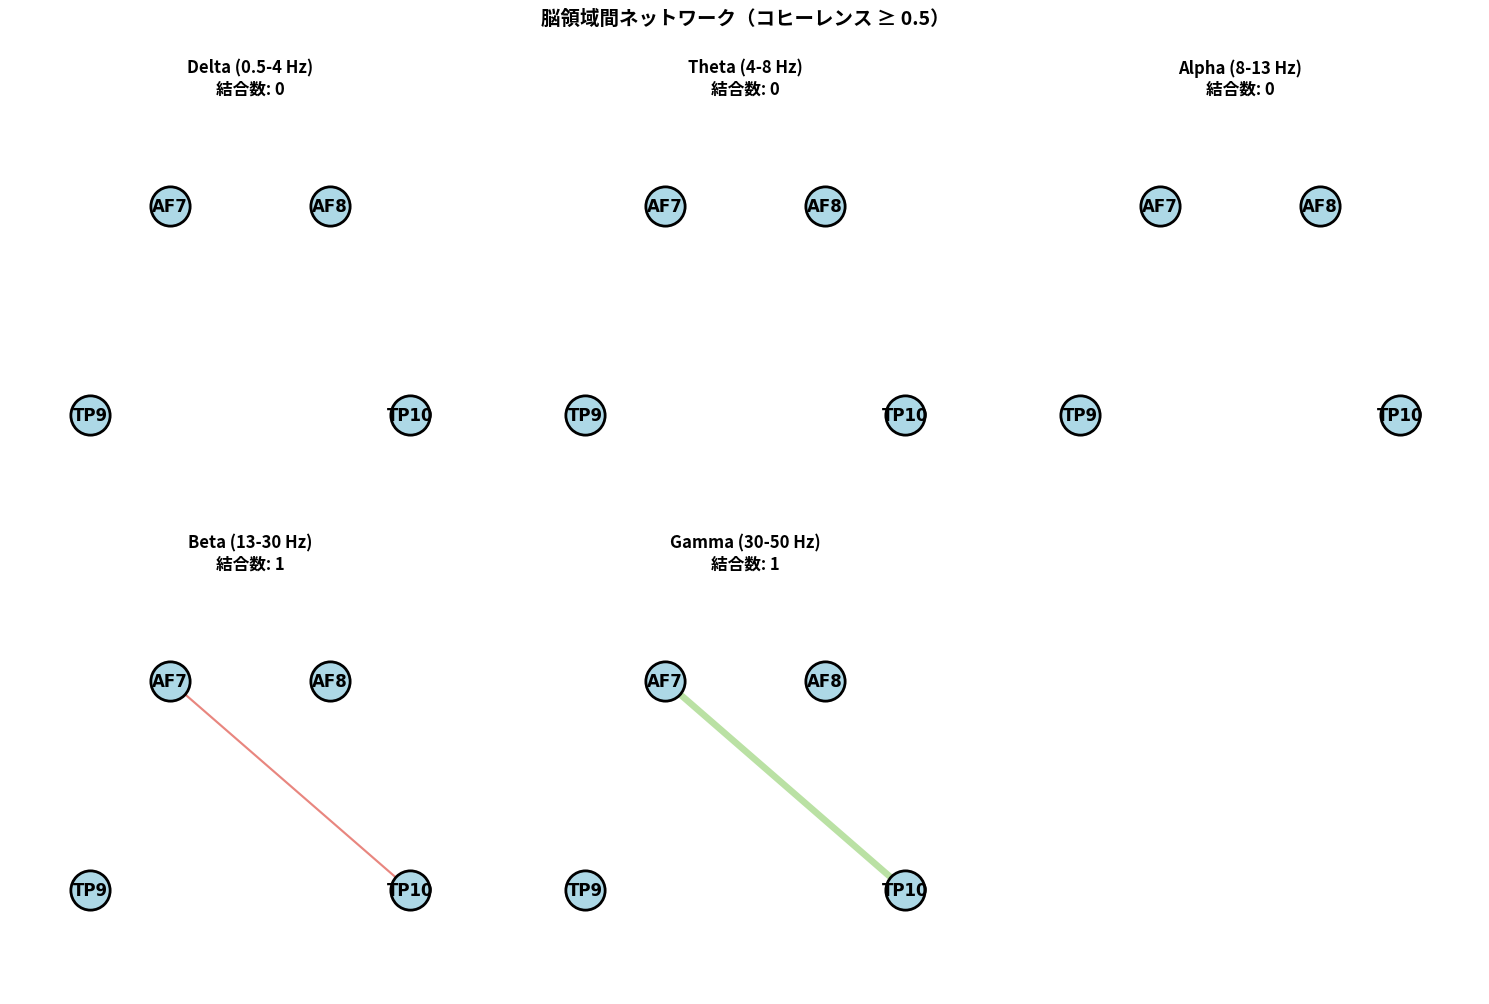


=== ネットワーク統計（閾値: 0.5） ===

Delta: 2/6 結合 (33.3%)
Theta: 2/6 結合 (33.3%)
Alpha: 2/6 結合 (33.3%)
Beta: 3/6 結合 (50.0%)
Gamma: 3/6 結合 (50.0%)


In [24]:
if 'coherence_avg' in locals():
    # networkxのインポートチェック
    try:
        import networkx as nx
        has_networkx = True
    except ImportError:
        print("警告: networkx がインストールされていません")
        print("ネットワーク図をスキップします")
        print("\nインストールする場合:")
        print("pip install networkx")
        has_networkx = False
    
    if has_networkx:
        # 閾値以上のコヒーレンスのみを表示
        threshold = 0.5
        
        # 各バンドのネットワーク図
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        
        # チャネル位置の定義（左右・前後の概略配置）
        pos = {
            'TP9': (-1, 0),    # 左側頭部
            'AF7': (-0.5, 1),  # 左前頭部
            'AF8': (0.5, 1),   # 右前頭部
            'TP10': (1, 0),    # 右側頭部
        }
        
        for idx, (band_name, (low, high)) in enumerate(band_ranges.items()):
            # バンド内の周波数マスク
            mask = (freqs >= low) & (freqs <= high)
            
            if mask.any():
                # バンド内の平均コヒーレンス
                band_coherence = coherence_avg[:, :, mask].mean(axis=2)
                
                # ネットワークグラフ作成
                G = nx.Graph()
                G.add_nodes_from(ch_names)
                
                # エッジ追加（閾値以上のコヒーレンス）
                edges = []
                weights = []
                for i in range(len(ch_names)):
                    for j in range(i + 1, len(ch_names)):
                        coh = band_coherence[i, j]
                        if coh >= threshold:
                            G.add_edge(ch_names[i], ch_names[j], weight=coh)
                            edges.append((ch_names[i], ch_names[j]))
                            weights.append(coh)
                
                # プロット
                ax = axes[idx]
                
                # ノード描画
                nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue',
                                      edgecolors='black', linewidths=2, ax=ax)
                
                # エッジ描画（太さをコヒーレンスに比例）
                if edges:
                    edge_widths = [(w - threshold) / (1 - threshold) * 5 + 1 for w in weights]
                    nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_widths,
                                          alpha=0.6, edge_color=weights, edge_cmap=plt.cm.RdYlGn,
                                          edge_vmin=threshold, edge_vmax=1, ax=ax)
                
                # ラベル描画
                nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', ax=ax)
                
                ax.set_title(f'{band_name} ({low}-{high} Hz)\n結合数: {len(edges)}',
                            fontsize=12, fontweight='bold')
                ax.axis('off')
                ax.set_xlim(-1.5, 1.5)
                ax.set_ylim(-0.5, 1.5)
        
        # 最後の空白サブプロット削除
        if len(band_ranges) < len(axes):
            fig.delaxes(axes[-1])
        
        plt.suptitle(f'脳領域間ネットワーク（コヒーレンス ≥ {threshold}）',
                    fontsize=14, fontweight='bold', y=1.00)
        plt.tight_layout()
        plt.show()
        
        print(f'\n=== ネットワーク統計（閾値: {threshold}） ===\n')
        for band_name, (low, high) in band_ranges.items():
            mask = (freqs >= low) & (freqs <= high)
            if mask.any():
                band_coherence = coherence_avg[:, :, mask].mean(axis=2)
                n_connections = np.sum(band_coherence >= threshold) // 2  # 対称行列なので半分
                max_connections = len(ch_names) * (len(ch_names) - 1) // 2
                connectivity_ratio = n_connections / max_connections * 100
                print(f'{band_name}: {n_connections}/{max_connections} 結合 ({connectivity_ratio:.1f}%)')
    else:
        # networkxなしで簡易的な統計のみ表示
        threshold = 0.5
        print(f'\n=== ネットワーク統計（閾値: {threshold}） ===\n')
        for band_name, (low, high) in band_ranges.items():
            mask = (freqs >= low) & (freqs <= high)
            if mask.any():
                band_coherence = coherence_avg[:, :, mask].mean(axis=2)
                n_connections = np.sum(band_coherence >= threshold) // 2
                max_connections = len(ch_names) * (len(ch_names) - 1) // 2
                connectivity_ratio = n_connections / max_connections * 100
                print(f'{band_name}: {n_connections}/{max_connections} 結合 ({connectivity_ratio:.1f}%)')
else:
    print('コヒーレンスデータが利用できません')

## まとめ

このノートブックでは、脳波データのコヒーレンス分析を行いました：

1. **チャネルペア別コヒーレンス**: 各チャネルペアの周波数ごとの同期性を確認
2. **周波数バンド別分析**: Delta、Theta、Alpha、Beta、Gammaバンドの結合性を比較
3. **時間変化**: コヒーレンスの経時的変化を追跡
4. **ネットワーク可視化**: 脳領域間の機能的結合をネットワーク図で表現

## コヒーレンスの解釈

- **高いコヒーレンス**: 脳領域間の情報統合・協調的な処理
- **低いコヒーレンス**: 独立した処理・機能的分離
- **バンド特異性**:
  - **Theta**: 記憶形成、瞑想状態
  - **Alpha**: リラックス、注意制御
  - **Beta**: 認知処理、運動制御
  - **Gamma**: 注意、意識統合

## 次のステップ

詳細な分析については、以下の専門ノートブックも参照してください：

- [mind_monitor_basic_analysis.ipynb](mind_monitor_basic_analysis.ipynb) - 基本的な脳波分析
- [laterality_analysis.ipynb](laterality_analysis.ipynb) - 左右半球の非対称性分析
- [fm_theta_analysis.ipynb](fm_theta_analysis.ipynb) - サマタ瞑想のfmシータ波分析